In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import time
import datetime
from typing import Dict, Tuple

# Load data

In [79]:
training_values = pd.read_csv("/content/train_set_values.csv")
training_labels = pd.read_csv("/content/train_set_labels.csv")

test_values = pd.read_csv("/content/test_set_values.csv")

In [80]:
dataset = training_values.join(other = training_labels.set_index('id'), on='id')

In [81]:
dataset.head().T

,0,1,2,3,4
id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A
gps_height,1390,1399,686,263,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni
num_private,0,0,0,0,0


In [82]:
dataset.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# Data preparation

In [83]:
dataset = dataset.drop(['id'], axis=1)

### Dataset has 0 longitude data, replace with mean values

In [84]:
def replace_zero_longitude_data(dataset: pd.DataFrame):
    dataset['longitude'] = dataset['longitude'].replace(0, dataset['longitude'].mean())

In [85]:
replace_zero_longitude_data(dataset)

## Convert True/False to string

In [86]:
def convert_column_to_string(dataset, column_name):
    dataset[column_name] = dataset[column_name].astype(str)

In [87]:
convert_column_to_string(dataset, 'permit')
convert_column_to_string(dataset, 'public_meeting')

## Categorical columns

In [88]:
categorical_columns = ['funder',
       'installer', 'wpt_name', 
       'basin', 'subvillage', 'region', 'lga',
       'ward', 'public_meeting',
       'scheme_management', 
       'scheme_name', 
       'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group',
       'status_group'] 

##  Handle N/A values

In [89]:
dataset.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

### Replace other NaN with 'n/a' value

In [90]:
def replace_na_value(dataset: pd.DataFrame):
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
        
        dataset[column] = dataset[column].fillna('n/a')

In [91]:
replace_na_value(dataset)

## Encode categorical columns

In [92]:
def encode_categorical_columns(dataset: pd.DataFrame) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
            
        le = LabelEncoder()
        le.fit(dataset[column])

        dataset[column] = le.transform(dataset[column])
        encoders[column]= le
        
    return encoders

In [93]:
encoders = encode_categorical_columns(dataset)

## Handle date columns


In [94]:
date_columns = ['date_recorded']

In [95]:
def convert_date_columns_to_epoch(dataset: pd.DataFrame, timestamp_format="%Y-%m-%d"):
    for column in date_columns:
        dataset[column] = [ datetime.datetime.strptime(x, timestamp_format).timestamp() for x in dataset[column]]

In [96]:
convert_date_columns_to_epoch(dataset)

### Drop 'recorded_by' because it has only one category value

In [97]:
def drop_recorded_by(dataset: pd.DataFrame):
    dataset.drop('recorded_by', axis=1, inplace=True)

In [98]:
drop_recorded_by(dataset)

In [99]:
def drop_derived_columns(dataset: pd.DataFrame):
    drop_columns = ['region', 
                    'extraction_type_group', 'extraction_type_class', 
                    'management_group', 
                    'payment', 
                    'quality_group', 
                    'quantity', 
                    'source_type', 'source_class', 
                    'waterpoint_type_group']
    dataset.drop(drop_columns,1, inplace=True)

In [100]:
drop_derived_columns(dataset)

## Normalize all columns

In [101]:
def scale_columns(dataset: pd.DataFrame):
    scaler = StandardScaler()
    dataset = scaler.fit_transform(dataset)

In [102]:
scale_columns(dataset)

# Create data preparation function for test data

In [103]:
def prepare_dataset(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    id_column = dataset['id']
    
    dataset = dataset.drop(['id'], axis=1)
    replace_zero_longitude_data(dataset)

    convert_column_to_string(dataset, 'permit')
    convert_column_to_string(dataset, 'public_meeting')

    replace_na_value(dataset)

    encode_categorical_columns(dataset)
    convert_date_columns_to_epoch(dataset)

    drop_recorded_by(dataset)
    drop_derived_columns(dataset)

    scale_columns(dataset)
    
    return dataset, id_column

# Train/ test split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.1, random_state = 0)

# Training different models

In [105]:
models_result = {}

In [106]:
def plot_features_importances(classifier, X_train):
    series = pd.Series(classifier.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    series = series.plot(kind='barh', figsize=(10,10))
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.show()

## Random forest

Random Forest has accuracy: 0.8183501683501684


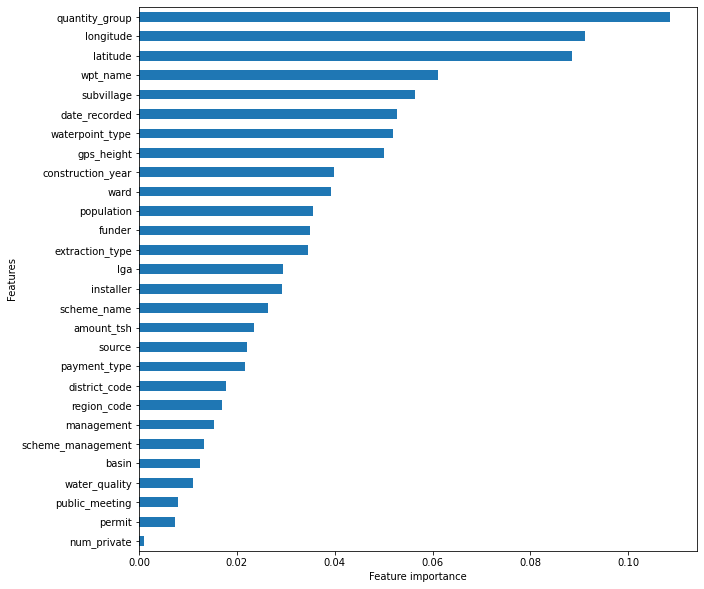

In [107]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=25, n_estimators = 42*5, criterion = 'entropy', random_state = 0)

rf_clf.fit(X_train, y_train)
accuracy = rf_clf.score(X_test, y_test)
models_result["Random Forest"] = accuracy
print(f'Random Forest has accuracy: {accuracy}') 
plot_features_importances(rf_clf, X_train)

## XGBoost

XGBoost has accuracy: 0.818013468013468


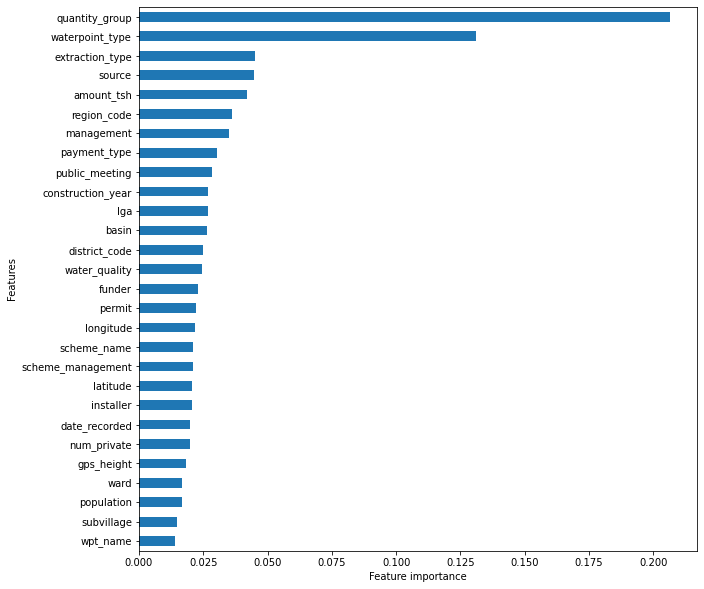

In [108]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(nthread=2, num_class=3, 
                        min_child_weight=3, max_depth=15,
                        gamma=0.5, scale_pos_weight=0.8,
                        subsample=0.7, colsample_bytree = 0.8,
                        objective='multi:softmax')
xgb_clf.fit(X_train, y_train)
accuracy = xgb_clf.score(X_test, y_test)
models_result["XGBoost"] = accuracy
print(f'XGBoost has accuracy: {accuracy}') 
plot_features_importances(xgb_clf, X_train)

"XGBoost" has accuracy: 0.818013468013468


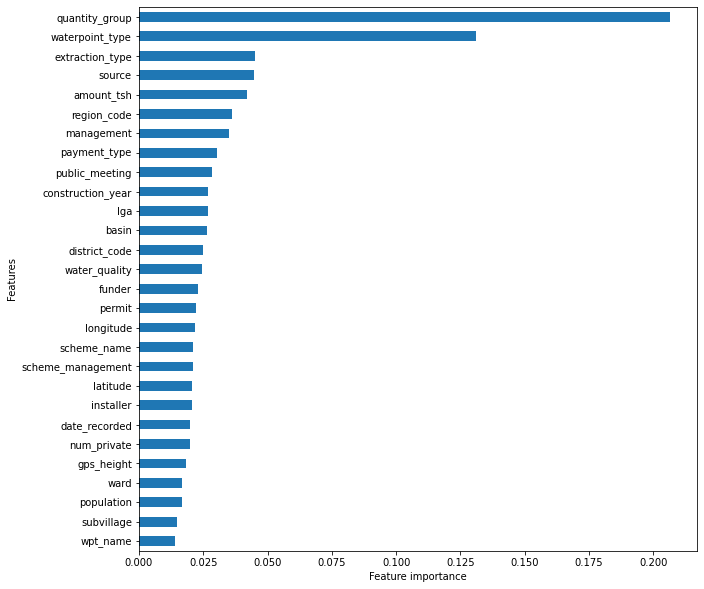

In [ ]:
xgb_clf = xgb(X_train, y_train)
update_result_print(models_result, 'XGBoost', xgb_clf, X_test, y_test)
plot_features_importances(xgb_clf, X_train)

# Results

In [109]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Random Forest             0.8183501683501684
XGBoost                   0.818013468013468


# Use best model to make prediction for test data

In [110]:
real_X, real_id_column = prepare_dataset(test_values)

In [111]:
real_y = rf_clf.predict(real_X)

## Decode result values

In [112]:
status_group_encoder = encoders['status_group']

In [113]:
real_decoded_y = pd.DataFrame(status_group_encoder.inverse_transform(real_y), columns = ['status_group'])

## Prepare submission file

In [ ]:
result = pd.concat([real_id_column, real_decoded_y], axis=1)

In [ ]:
result.to_csv("/content/submisssion.csv", index=False)